# Augustine Source Inversion Figure

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pickle
import pandas as pd
import rasterio
import pyproj
import fiona
import numpy as np
import emcee
import station_positions
import draw_sources

import vmod.data
import vmod.source

import sys
sys.path.append("./augustineInversion/")
import tilt_fwd

matplotlib.rc('pdf', fonttype=42)

plt.style.use("/home/mchristo/proj/libmsc/style/msc.mplstyle")

## Load measured tilts and inversion params

In [2]:
with open("./augustineInversion/event_tilts.pkl", mode="rb") as fd:
    dfmeas = pickle.load(fd)

In [3]:
# Load samples
sampler = emcee.backends.HDFBackend("./augustineInversion/samples/yang_nish_100nr_nm.h5")

samps = sampler.get_chain(discard=150000, thin=10, flat=True)

## Load station locations, contours, hillshade map

In [4]:
# url to get station locations
# Built here:
# https://service.iris.edu/fdsnws/station/docs/1/builder/
url_aug = "https://service.iris.edu/fdsnws/station/1/query?net=AV&sta=AU11,AU12,AU13,AU14&cha=HHE&starttime=2005-11-01&endtime=2006-05-01&level=station&format=text&includecomments=true&nodata=404"
df_aug = pd.read_csv(url_aug, sep="|")
xform = pyproj.Transformer.from_crs("4326", "3338")
df_aug["x"], df_aug["y"] = xform.transform(df_aug[" Latitude "], df_aug[" Longitude "])

df_aug["station"] = df_aug[" Station "]
dfmeas = pd.merge(dfmeas, df_aug[["x", "y", "station"]], on="station")

In [5]:
contours = []
with fiona.open("./data/topo/augustine_ifsar_contour.gpkg") as fd:
    for line in fd:
        contours.append(list(zip(*line['geometry']['coordinates'])))

In [6]:
with rasterio.open("./data/topo/augustine_ifsar_hillshade.tif", "r") as src:
    left, bottom, right, top = src.bounds
    hillshade = src.read(1)

with rasterio.open("./data/topo/augustine_ifsar.tif", "r") as src:
    hgt_aug = src.read(1)

## Calculate median tilt from inversion results

In [7]:
# Make randomly drawn tilt scenarios
events = [2, 3, 4, 6, 9, 11, 13]
fwm = tilt_fwd.TiltFwd()
n = 500
indxs = (np.random.rand(n) * len(samps)).astype(np.int32)
modtilts_e = []
modtilts_n = []
for i in indxs:
    sta, tx, ty = fwm.tilt(samps[i, :])
    modtilts_e.append(tx)
    modtilts_n.append(ty)

# Get median tilt
median_tilts = {}

for i in range(len(events)):
    ntil = np.zeros((len(modtilts_n), len(modtilts_n[0][i])))
    etil = np.zeros((len(modtilts_e), len(modtilts_e[0][i])))
    for j in range(n):
        ntil[j, :] = modtilts_n[j][i]
        etil[j, :] = modtilts_e[j][i]

    median_tilts[events[i]] = (
        np.nanmedian(ntil, axis=0),
        np.nanmedian(etil, axis=0),
    )

## Make plot

In [10]:
# Draw sources
x = np.median(samps, axis=0)
i = 2
xyang = np.concatenate((x[:3], [x[10 + (i * 3)] * 1e6], x[3:7]))
# xcen, ycen, depth, radius, length and pressure
xnish = np.concatenate(
    (
        x[7:9],
        [x[12 + (i * 3)] / 2],
        [x[9]],
        [x[12 + (i * 3)]],
        [x[11 + (i * 3)] * 1e6],
    )
)

yx, yy, yz = draw_sources.yang(xyang)
nx, ny, nz = draw_sources.nish(xnish)

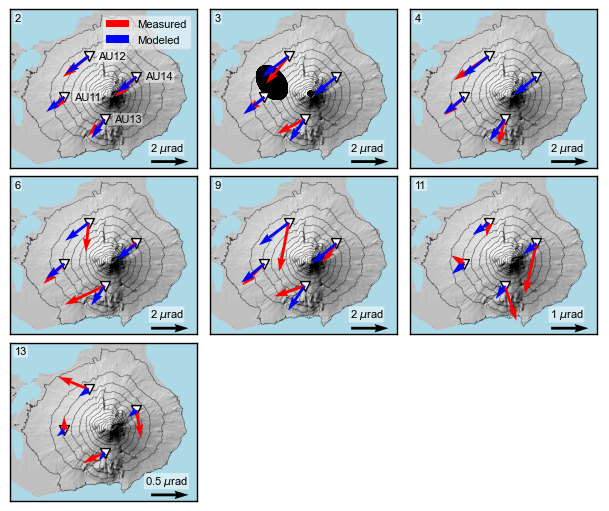

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(6, 5), constrained_layout=True)

axs = axs.flatten()

letters = ["a", "b", "c", "d", "e", "f"]

hillshade = hillshade.astype(np.float32)
hillshade[hgt_aug == 0] = np.nan

df, ox, oy = station_positions.station_positions()
df = df[df[" Station "] != "AU15"]

for i, event in enumerate(events):
    axs[i].grid(False)
    axs[i].set_facecolor("lightblue")

    # Hillshade
    axs[i].imshow(
        hillshade,
        cmap="Greys_r",
        extent=[left, right, bottom, top],
        vmin=50,
        vmax=255,
        zorder=0,
    )
    axs[i].set(
        xlim=(left + 12e3, right - 5e3),
        ylim=(bottom + 8e3, top - 10.5e3),
        xticks=[],
        yticks=[],
    )
    axs[i].set_aspect("equal")

    # Contours
    for contour in contours:
        axs[i].plot(
            contour[0], contour[1], "k-", alpha=0.5, linewidth=0.5, zorder=1
        )

    # Stations
    axs[i].scatter(
        df["x"],
        df["y"],
        marker="v",
        s=50,
        edgecolor="k",
        facecolor="w",
        zorder=3
    )

    # Station labels for first panel
    if(i == 0):
        for j, row in df_aug.iterrows():
            axs[i].text(row["x"]+1.5e3, row["y"], row[" Station "].strip(),
                    horizontalalignment="center",
                    verticalalignment="center",
                    fontsize=8,
                    zorder=4,
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
            )

    # Source location for second panel
    if(i == 1):
        axs[i].plot(ox+yx, oy+yy, '.', zorder=2)
        axs[i].plot(ox+nx, oy+ny, '.', zorder=2)    


    # Measured tilt
    dfmeas_sub = dfmeas[dfmeas["event"] == event]

    
    scale = 1e-5
    arrow = 2e-6
    alabel = "2"
    
    if(event in [11]):
        scale /= 2
        arrow /= 2
        alabel = "1"
        
    if(event in [13]):
        scale /= 4
        arrow /= 4
        alabel = "0.5"
        
    # Add scale arrow
    axs[i].quiver([35e3], [1036.5e3], [arrow], [0], scale=scale, color="k", width=0.015)

    # Add label
    axs[i].annotate(
        "%s $\\mu$rad" % alabel,
        (36e3, 1037.2e3),
        fontsize=8,
        horizontalalignment="center",
        bbox=dict(
            facecolor="white", edgecolor="none", boxstyle="round,pad=0.1", alpha=0.5
        ),
    )

    axs[i].quiver(
        dfmeas_sub["x"], 
        dfmeas_sub["y"], 
        dfmeas_sub["etilt"], 
        dfmeas_sub["ntilt"], 
        scale=scale, 
        label="Measured", 
        color="r",
        width=0.015,
        zorder=4
    )

    median_tilts_sub = median_tilts[event]
    axs[i].quiver(
        df["x"], 
        df["y"], 
        median_tilts_sub[0], 
        median_tilts_sub[1], 
        scale=scale, 
        label="Modeled", 
        color="b",
        width=0.015,
        zorder=4
    )

    if i == 0:
        # Add legend
        axs[i].legend(loc="upper right", framealpha=0.5, fontsize=8)

    # Add label
    axs[i].annotate(
        event,
        (0.025, 0.925),
        xycoords="axes fraction",
        fontsize=8,
        bbox=dict(
            facecolor="white", edgecolor="none", boxstyle="round,pad=0.1", alpha=0.5
        ),
    )

axs[7].set_axis_off()
axs[8].set_axis_off()

fig.savefig("./figs/augustine_inversion.pdf", bbox_inches="tight")

fig.savefig("./figs/png/augustine_inversion.png", dpi=300, bbox_inches="tight")